# COVID-19 Death Rate Analysis

## Import Libraries

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
from IPython import InteractiveShell

## Set the display settings

In [2]:
InteractiveShell.ast_node_interactivity = "all"
plt.style.use("seaborn-talk")
pd.options.display.max_rows = 1000

## Load data

In [3]:
data_file_path = "/Users/andrei_assa/Desktop/MQM Project/County_covid19_deaths_0201+population+vote (usafacts)2.csv"
data = pd.read_csv(data_file_path)

## Create dictionary with start and stop dates for NPIs by state

In [4]:
state_mandates = {
    "AZ":{"start":None, "stop":None},
    "GA":{"start":"08/31/2020", "stop":None},
    "MI":{"start":"07/17/2020", "stop":None},
    "PA":{"start":"07/01/2020", "stop":None},
    "WI":{"start":"08/01/2020", "stop":None}
}

## Create functions to process data

In [5]:
def get_dataframes(state):
    """Return dataframe containining only data for given state.
    
    Parameters
    ----------
    state : str state name.
    
    """
    return data[data.State==state]

def format_dataframe(dataframe):
    """
    Return dataframe with index set as state and county name;
    All column apart from population and date columns are removed.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame containing state data.
    
    """
    
    dataframe = dataframe.set_index(["State", "CountyName"])
    
    def get_date_and_population_columns(column_list):
        """
        Return list of columns containing date and population columns.
        
        Parameters
        ----------
        column_list : list of columns from dataframe.
        
        """
        new_column_list = []
        for column in column_list:
            if column.lower() == "population" or "/" in column:
                new_column_list.append(column)
        return new_column_list
    
    column_list = dataframe.columns.to_list()
    population_and_date_cols = get_date_and_population_columns(column_list)
    
    dataframe = dataframe[population_and_date_cols]
    
    return dataframe

def get_total_population(population_vector):
    return population_vector.sum()

def calculate_daily_deaths(dataframe, state):
    """
    Calculate the number of daily deaths.
    
    Parameters
    ----------
    
    dataframe : pandas.DataFrame containing state data.
    state : str state name.
    
    returns : new_deaths_on_day_t_whole_state, population_col
    
    """
    # Separate the population column from the rest.
    population_col = dataframe.population
    total_deaths_at_day_t = dataframe.drop("population", axis=1)
    
    # Calculate the difference from the previous day.
    new_deaths_on_day_t_by_county = total_deaths_at_day_t.diff(1, axis=1)
    
    # Transpose so that dates are rows and counties are columns.
    new_deaths_on_day_t_by_county = new_deaths_on_day_t_by_county.transpose()
    
    # Sum along axis=1 to get total new cases in state per day.
    new_deaths_on_day_t_whole_state = new_deaths_on_day_t_by_county.sum(axis=1)
    
    return new_deaths_on_day_t_whole_state, population_col

def calculate_deaths_per_100k(new_deaths_on_day_t_whole_state, population_col):
    """
    Calculate the number of new cases per 100,000 persons.
    
    Parameters
    ----------
    
    dataframe : pandas.DataFrame containing state data.
    state : str state name.
    
    returns : new_deaths_on_day_t_whole_state, population_col
    
    """
    
    # Sum the values in the population_col to get the total state population
    state_population = get_total_population(population_col)
    
    # Deaths per capita = new deaths on day t / population
    deaths_per_capita_per_day_whole_state = new_deaths_on_day_t_whole_state / state_population
    
    # Deaths per 100K = deaths per capita * 100000    
    deaths_per_100k_whole_state = deaths_per_capita_per_day_whole_state * 100000
    
    return deaths_per_100k_whole_state
    
def add_state_label(covid_rate_series, state):
    
    dataframe = covid_rate_series.to_frame()
    
    if state != "AZ":
        dataframe[state] = 1
    else:
        dataframe[state] = 0
    dataframe.columns = ["daily_deaths_per_100k", state]
    
    return dataframe

def label_intervention_date(state_data, state):
    
    intervention_start = state_mandates[state]["start"]
    state_data["intervention"] = 0
    intervention_filter = state_data.index >= intervention_start
    state_data.loc[intervention_filter, "intervention"] = 1
    return state_data

## Validate the functions
#### Ensure we are getting expected output from above functions

State = MI
Population = 9986857.0
Data sample:


1/22/20    0.0
1/23/20    0.0
1/24/20    0.0
1/25/20    0.0
1/26/20    0.0
dtype: float64

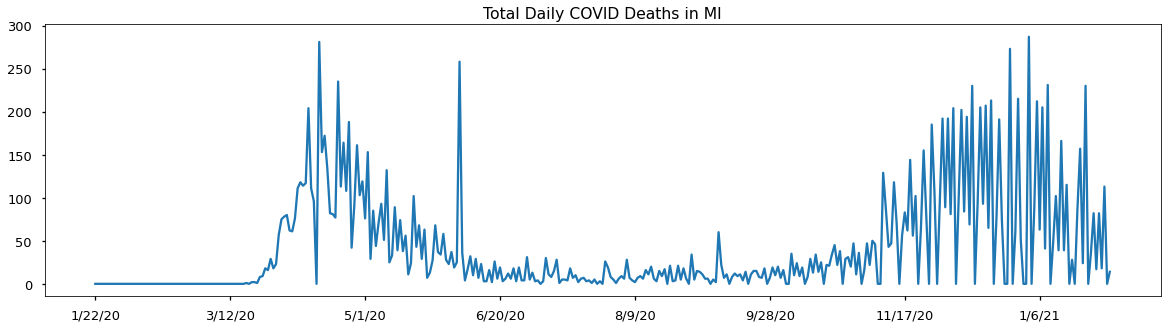

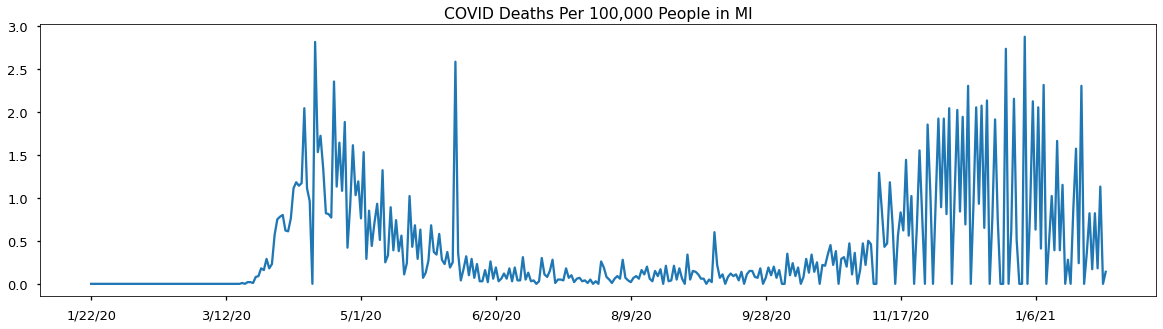

In [6]:
state = "MI"
figsize= (20, 5)
state_population = get_total_population(data[data.State==state].population)

print(f"State = {state}")
print(f"Population = {state_population}")
print("Data sample:")
# Filter data by state
state_data = get_dataframes(state)
# Format the filtered data.
formatted_data = format_dataframe(state_data)
# Get the total daily death count.
daily_deaths, population_col = calculate_daily_deaths(formatted_data, state)
deaths_per_100k = calculate_deaths_per_100k(daily_deaths, population_col)

_ = plt.figure(figsize=figsize)
_ = daily_deaths.plot(title=f"Total Daily COVID Deaths in {state}")

deaths_per_100k.head()
_ = plt.figure(figsize=figsize)
_ = deaths_per_100k.plot(title=f"COVID Deaths Per 100,000 People in {state}")

**This seems correct; Michigan's population is ~10M, that means deaths per 100,000 were around 3 in April 2020, and were again at that same level in January 2021.**

In [7]:
state_dataframes = {}
# Iterate over all keys in state_mandates
for state in state_mandates.keys():
    
    # Filter data by state     
    state_data = get_dataframes(state)
    # Format the filtered data.
    formatted_data = format_dataframe(state_data)
    # Get the total daily death count and population data
    daily_deaths, population_col = calculate_daily_deaths(formatted_data, state)
    deaths_per_100k = calculate_deaths_per_100k(daily_deaths, population_col)
    
    labeled_data = add_state_label(deaths_per_100k, state)
    labeled_data.index = pd.to_datetime(labeled_data.index)
    if state != "AZ":
        labeled_data = label_intervention_date(labeled_data, state)
    else:
        labeled_data["intervention"] = 0
    state_dataframes[state] = labeled_data

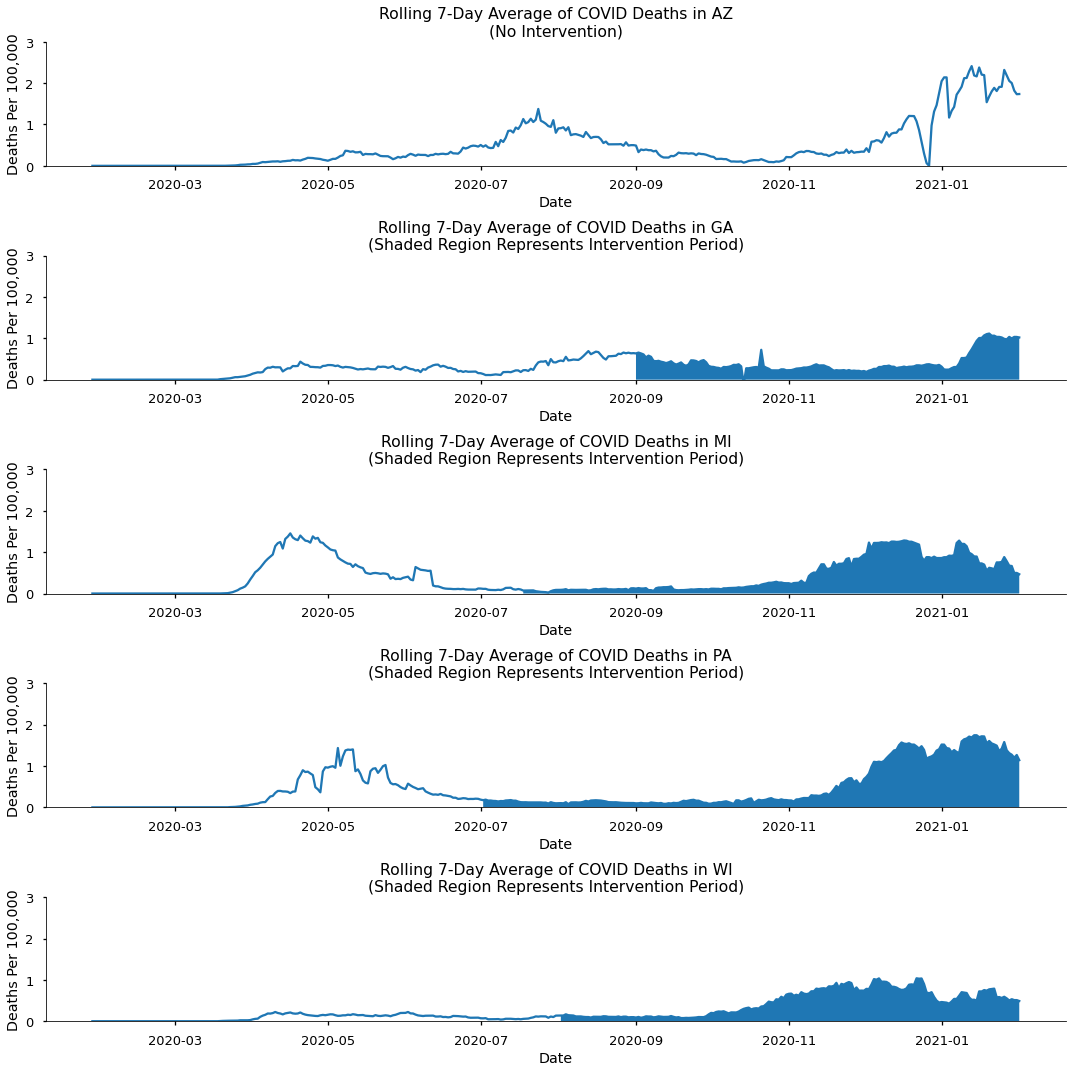

In [8]:


rolling_average_days = 7

num_plots = len(state_dataframes)
fig = plt.figure(figsize=(15,15))
for index, state in enumerate(state_dataframes.keys()):
    
    ax = fig.add_subplot(num_plots,1, index+1)
    intervention_start = state_mandates[state]["start"]
    y = state_dataframes[state].daily_deaths_per_100k.rolling(rolling_average_days).mean()
    x = y.index
    _ = ax.plot(y)
    _ = ax.set_ylim(0, 3)
    _ = ax.set_ylabel("Deaths Per 100,000")
    _ = ax.set_xlabel("Date")
    if intervention_start is not None:
        title = f"Rolling {rolling_average_days}-Day Average of COVID Deaths in {state}\n(Shaded Region Represents Intervention Period)"
        date_after_intervention = (x>intervention_start)
        _ = ax.fill_between(x, 0, y, where=date_after_intervention)
    else:
        title = f"Rolling {rolling_average_days}-Day Average of COVID Deaths in {state}\n(No Intervention)"
    _ = ax.set_title(title)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()

In [9]:
def combine_dataframes(dataframe):
    az = state_dataframes["AZ"]
    state_name = dataframe.columns[-2]
    az = az.rename({"AZ":state_name}, axis=1)
    output = pd.concat([dataframe, az])
    return output

In [10]:
for state in state_dataframes.keys():
    if state != "AZ":
        combined_df = combine_dataframes(state_dataframes[state])
        formula = f'daily_deaths_per_100k ~ {state} + intervention + {state} * intervention'
        mod = sm.ols(formula=formula, data = combined_df)
        res = mod.fit()
        res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     daily_deaths_per_100k   R-squared:                       0.027
Model:                               OLS   Adj. R-squared:                  0.025
Method:                    Least Squares   F-statistic:                     10.48
Date:                   Mon, 08 Mar 2021   Prob (F-statistic):           3.25e-05
Time:                           03:22:49   Log-Likelihood:                -717.66
No. Observations:                    754   AIC:                             1441.
Df Residuals:                        751   BIC:                             1455.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4783      0.032     14.786      0.000       0.415       0.542
GA                 -0.2407      0.053     -4.531      0.000      -0.345      -0.136
intervention        0.0943      0.033      2.870      0.004       0.030       0.159
GA:intervention     0.0943      0.033      2.870      0.004       0.030       0.159
==============================================================================
Omnibus:                      607.845   Durbin-Watson:                   1.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16708.726
Skew:                           3.433   Prob(JB):                         0.00
Kurtosis:                      25.016   Cond. No.                     2.12e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.46e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     daily_deaths_per_100k   R-squared:                       0.005
Model:                               OLS   Adj. R-squared:                  0.002
Method:                    Least Squares   F-statistic:                     1.774
Date:                   Mon, 08 Mar 2021   Prob (F-statistic):              0.170
Time:                           03:22:50   Log-Likelihood:                -806.93
No. Observations:                    754   AIC:                             1620.
Df Residuals:                        751   BIC:                             1634.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4783      0.036     13.135      0.000       0.407       0.550
MI                 -0.1193      0.064     -1.852      0.064      -0.246       0.007
intervention        0.0506      0.036      1.387      0.166      -0.021       0.122
MI:intervention     0.0506      0.036      1.387      0.166      -0.021       0.122
==============================================================================
Omnibus:                      514.491   Durbin-Watson:                   1.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6646.436
Skew:                           2.967   Prob(JB):                         0.00
Kurtosis:                      16.280   Cond. No.                     2.84e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.47e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     daily_deaths_per_100k   R-squared:                       0.011
Model:                               OLS   Adj. R-squared:                  0.009
Method:                    Least Squares   F-statistic:                     4.341
Date:                   Mon, 08 Mar 2021   Prob (F-statistic):             0.0134
Time:                           03:22:50   Log-Likelihood:                -835.10
No. Observations:                    754   AIC:                             1676.
Df Residuals:                        751   BIC:                             1690.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4783      0.038     12.653      0.000       0.404       0.552
PA                 -0.1557      0.069     -2.254      0.024      -0.291      -0.020
intervention        0.1107      0.038      2.896      0.004       0.036       0.186
PA:intervention     0.1107      0.038      2.896      0.004       0.036       0.186
==============================================================================
Omnibus:                      509.605   Durbin-Watson:                   0.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6149.330
Skew:                           2.957   Prob(JB):                         0.00
Kurtosis:                      15.679   Cond. No.                     8.77e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.58e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     daily_deaths_per_100k   R-squared:                       0.071
Model:                               OLS   Adj. R-squared:                  0.068
Method:                    Least Squares   F-statistic:                     28.59
Date:                   Mon, 08 Mar 2021   Prob (F-statistic):           1.08e-12
Time:                           03:22:50   Log-Likelihood:                -703.07
No. Observations:                    754   AIC:                             1412.
Df Residuals:                        751   BIC:                             1426.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4783      0.032     15.075      0.000       0.416       0.541
WI                 -0.3948      0.055     -7.229      0.000      -0.502      -0.288
intervention        0.1887      0.032      5.947      0.000       0.126       0.251
WI:intervention     0.1887      0.032      5.947      0.000       0.126       0.251
==============================================================================
Omnibus:                      643.948   Durbin-Watson:                   0.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18157.486
Skew:                           3.752   Prob(JB):                         0.00
Kurtosis:                      25.839   Cond. No.                     1.43e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.67e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**We can see that each state has a negative coefficient relative to AZ, indicating that each of these states had a lower death rate per 100,000 than AZ.**

In [11]:
mask_mandates = pd.ExcelFile("State mask mandate dates_0202.xlsx")

In [14]:
mask_madates_data = mask_mandates.parse(1)

In [15]:
mask_madates_data.set_index(mask_madates_data.columns[0], inplace=True)

In [17]:
mask_madates_data.index.name="State"

In [21]:
mask_mandate_dates = mask_madates_data.Date.to_frame()

In [22]:
mask_mandate_dates

,Date
State,
Alabama,2021-07-16
Arizona,NaT
Arkansas,2021-07-20
California,2021-06-18
Colorado,2021-07-16
Connecticut,2021-04-20
Delaware,2021-04-28
District of Columbia,2021-07-22
Florida,NaT


In [23]:
data

,countyFIPS,CountyName,State,stateFIPS,population,Dem_share2016,Rep_share2016,Dem_vote2016,Rep_vote2016,Dem_share2020,...,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21
0,0,Statewide Unallocated,AL,1,NaN,34.36%,62.08%,"729,547","1,318,255",36.57%,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,55869.0,23.77%,72.77%,"5,936","18,172",27.02%,...,62,62,62,65,67,69,69,69,69,69
2,1003,Baldwin County,AL,1,223234.0,19.39%,76.55%,"18,458","72,883",22.41%,...,189,189,189,216,217,224,224,224,224,224
3,1005,Barbour County,AL,1,24686.0,46.53%,52.10%,"4,871","5,454",45.79%,...,38,38,38,40,40,40,40,40,40,40
4,1007,Bibb County,AL,1,22394.0,21.25%,76.40%,"1,874","6,738",20.70%,...,48,48,48,51,51,51,51,51,52,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156,56037,Sweetwater County,WY,56,42343.0,18.86%,70.95%,"3,231","12,154",23.03%,...,30,30,30,32,32,32,32,32,32,32
3157,56039,Teton County,WY,56,23464.0,57.92%,31.05%,"7,314","3,921",67.10%,...,5,5,5,6,6,6,6,6,6,6
3158,56041,Uinta County,WY,56,20226.0,14.19%,72.66%,"1,202","6,154",16.92%,...,12,12,12,12,12,12,12,12,12,12
3159,56043,Washakie County,WY,56,7805.0,13.95%,76.32%,532,"2,911",16.23%,...,25,25,25,25,25,25,25,25,25,25


In [35]:
state_abbreviations = pd.read_html("https://www.ssa.gov/international/coc-docs/states.html")[0]

In [36]:
state_abbreviations.columns = ["State", "Abbreviation"]
state_abbreviations.State = state_abbreviations.State.str.title()
state_abbreviations = state_abbreviations.set_index("State")
state_abbreviations = state_abbreviations.to_dict()["Abbreviation"]
state_abbreviations

{'Alabama': 'AL',
 'Alaska': 'AK',
 'American Samoa': 'AS',
 'Arizona': 'AZ',
 'Arkansas': 'AR',
 'California': 'CA',
 'Colorado': 'CO',
 'Connecticut': 'CT',
 'Delaware': 'DE',
 'District Of Columbia': 'DC',
 'Florida': 'FL',
 'Georgia': 'GA',
 'Guam': 'GU',
 'Hawaii': 'HI',
 'Idaho': 'ID',
 'Illinois': 'IL',
 'Indiana': 'IN',
 'Iowa': 'IA',
 'Kansas': 'KS',
 'Kentucky': 'KY',
 'Louisiana': 'LA',
 'Maine': 'ME',
 'Maryland': 'MD',
 'Massachusetts': 'MA',
 'Michigan': 'MI',
 'Minnesota': 'MN',
 'Mississippi': 'MS',
 'Missouri': 'MO',
 'Montana': 'MT',
 'Nebraska': 'NE',
 'Nevada': 'NV',
 'New Hampshire': 'NH',
 'New Jersey': 'NJ',
 'New Mexico': 'NM',
 'New York': 'NY',
 'North Carolina': 'NC',
 'North Dakota': 'ND',
 'Northern Mariana Is': 'MP',
 'Ohio': 'OH',
 'Oklahoma': 'OK',
 'Oregon': 'OR',
 'Pennsylvania': 'PA',
 'Puerto Rico': 'PR',
 'Rhode Island': 'RI',
 'South Carolina': 'SC',
 'South Dakota': 'SD',
 'Tennessee': 'TN',
 'Texas': 'TX',
 'Utah': 'UT',
 'Vermont': 'VT',
 'Virgi

In [76]:
from datetime import datetime

total_results = pd.DataFrame()

for state in mask_mandate_dates.index:
        
    abbreviation = state_abbreviations.get(state, None)
    if abbreviation is None:
        continue

    result = get_dataframes(abbreviation)
    formatted_data = format_dataframe(result)
    daily_deaths, population_col = calculate_daily_deaths(formatted_data, state)
    deaths_per_100k = calculate_deaths_per_100k(daily_deaths, population_col)
    deaths_per_100k = deaths_per_100k.to_frame()
    deaths_per_100k.index.name = "date"
    deaths_per_100k.index = pd.to_datetime(deaths_per_100k.index)
    deaths_per_100k.columns = ["deaths_per_100k"]
    deaths_per_100k = deaths_per_100k.reset_index()
    deaths_per_100k["state"] = abbreviation
    deaths_per_100k = deaths_per_100k.set_index(["state", "date"])
    
    intervention_date = mask_mandate_dates["Date"].loc[state]
    if intervention_date > datetime.today():
        intervention_date = intervention_date - pd.Timedelta(366, "d")
    deaths_per_100k["intervention_period"] = None
    for (state, date), row in deaths_per_100k.iterrows():
        difference = (date - intervention_date).days
        
        if difference <= -16:
            label = "-16 and earlier"
        elif -15 <= difference < -11:
            label = "-15 to -11"
        elif -10 <= difference < -6:
            label = "-10 to -6"
        elif -5 <= difference < -1:
            label = "-5 to -1"
        elif 1 <= difference < 5:
            label = "1 to 5"
        elif 6 <= difference < 10:
            label = "6 to 10"
        elif 11 <= difference < 15:
            label = "11 to 15"
        elif 16 <= difference < 20:
            label = "16 to 20"
        elif difference >= 21:
            label = "21 or more"
        
        row_filter = deaths_per_100k.index == (state, date)
        deaths_per_100k.loc[row_filter, "intervention_period"] = label
    
    total_results = pd.concat([total_results, deaths_per_100k])

In [83]:
total_results.to_csv("labeled_data.csv")

In [51]:
deaths_per_100k

deaths_per_100k
state date                     
AL    1/22/20          0.000000
      1/23/20          0.000000
      1/24/20          0.000000
      1/25/20          0.000000
      1/26/20          0.000000
      1/27/20          0.000000
      1/28/20          0.000000
      1/29/20          0.000000
      1/30/20          0.000000
      1/31/20          0.000000
      2/1/20           0.000000
      2/2/20           0.000000
      2/3/20           0.000000
      2/4/20           0.000000
      2/5/20           0.000000
      2/6/20           0.000000
      2/7/20           0.000000
      2/8/20           0.000000
      2/9/20           0.000000
      2/10/20          0.000000
      2/11/20          0.000000
      2/12/20          0.000000
      2/13/20          0.000000
      2/14/20          0.000000
      2/15/20          0.000000
      2/16/20          0.000000
      2/17/20          0.000000
      2/18/20          0.000000
      2/19/20          0.000000
      2/20/20          0.000000
      2/21/20          0.000000
      2/22/20          0.000000
      2/23/20          0.000000
      2/24/20          0.000000
      2/25/20          0.000000
      2/26/20          0.000000
      2/27/20          0.000000
      2/28/20          0.000000
      2/29/20          0.000000
      3/1/20           0.000000
      3/2/20           0.000000
      3/3/20           0.000000
      3/4/20           0.000000
      3/5/20           0.000000
      3/6/20           0.000000
      3/7/20           0.000000
      3/8/20           0.000000
      3/9/20           0.000000
      3/10/20          0.000000
      3/11/20          0.000000
      3/12/20          0.000000
      3/13/20          0.000000
      3/14/20          0.000000
      3/15/20          0.000000
      3/16/20          0.000000
      3/17/20          0.000000
      3/18/20          0.000000
      3/19/20          0.000000
      3/20/20          0.000000
      3/21/20          0.000000
      3/22/20          0.000000
      3/23/20          0.000000
      3/24/20          0.000000
      3/25/20          0.020395
      3/26/20          0.000000
      3/27/20          0.020395
      3/28/20          0.020395
      3/29/20          0.020395
      3/30/20          0.040790
      3/31/20          0.142764
      4/1/20           0.061185
      4/2/20           0.020395
      4/3/20           0.081580
      4/4/20           0.101975
      4/5/20           0.101975
      4/6/20           0.020395
      4/7/20           0.142764
      4/8/20           0.183554
      4/9/20           0.000000
      4/10/20          0.203949
      4/11/20          0.040790
      4/12/20          0.020395
      4/13/20          0.000000
      4/14/20          0.244739
      4/15/20          0.040790
      4/16/20          0.142764
      4/17/20          0.285529
      4/18/20          0.285529
      4/19/20          0.040790
      4/20/20          0.000000
      4/21/20          0.591452
      4/22/20          0.673032
      4/23/20          0.407898
      4/24/20          0.285529
      4/25/20          0.081580
      4/26/20          0.122369
      4/27/20          0.183554
      4/28/20          0.265134
      4/29/20          0.428293
      4/30/20          0.163159
      5/1/20           0.367108
      5/2/20           0.000000
      5/3/20           0.040790
      5/4/20           0.163159
      5/5/20           0.346713
      5/6/20           0.550662
      5/7/20           0.550662
      5/8/20           0.265134
      5/9/20           0.142764
      5/10/20          0.061185
      5/11/20          0.203949
      5/12/20          0.754612
      5/13/20          0.203949
      5/14/20          0.448688
      5/15/20          0.244739
      5/16/20          0.000000
      5/17/20          0.061185
      5/18/20          0.020395
      5/19/20          0.285529
      5/20/20          0.448688
      5/21/20          0.142764
      5/22/20          0.244739
      5/23/20          0.203949
      5/24/20   

,daily_deaths_per_100k,WI,intervention
2020-01-22,0.000000,1,0
2020-01-23,0.000000,1,0
2020-01-24,0.000000,1,0
2020-01-25,0.000000,1,0
2020-01-26,0.000000,1,0
2020-01-27,0.000000,1,0
2020-01-28,0.000000,1,0
2020-01-29,0.000000,1,0
2020-01-30,0.000000,1,0
2020-01-31,0.000000,1,0
